# Crypto Currency Cross-Prediction 02

## 2020-02-10 ~ 2023-12-31 

In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from util import *
from nbeat import *

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Define the date range
# start_date = datetime(2023, 1, 1)  # Start date in milliseconds
# end_date = datetime(2023, 11, 1)    # End date in milliseconds (exclusive)# Fetch historical data
# bnb_data = fetchHistoricalData('BNBUSDT', start_date, end_date)
# read csv file
# use fetch-historical-data.py to fetch data
bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')

if bnb_data is not None:
    print(bnb_data)

       Open Time     Open     High      Low    Close      volume
0     2020-02-10   25.070   25.907   24.031   25.189  1405091.86
1     2020-02-11   25.190   25.864   24.250   25.705  1783061.99
2     2020-02-12   25.705   26.980   25.347   26.451  1311285.47
3     2020-02-13   26.452   27.397   24.580   25.456  1451755.42
4     2020-02-14   25.455   26.697   25.043   26.384  1271237.03
...          ...      ...      ...      ...      ...         ...
1416  2023-12-27  297.500  324.130  285.000  323.760  3928291.07
1417  2023-12-28  323.750  337.730  319.200  322.210  4582442.88
1418  2023-12-29  322.200  325.250  306.460  313.290  2408793.98
1419  2023-12-30  313.290  320.480  311.840  316.710  1141399.89
1420  2023-12-31  316.690  324.790  306.380  311.330  1294462.46

[1421 rows x 6 columns]


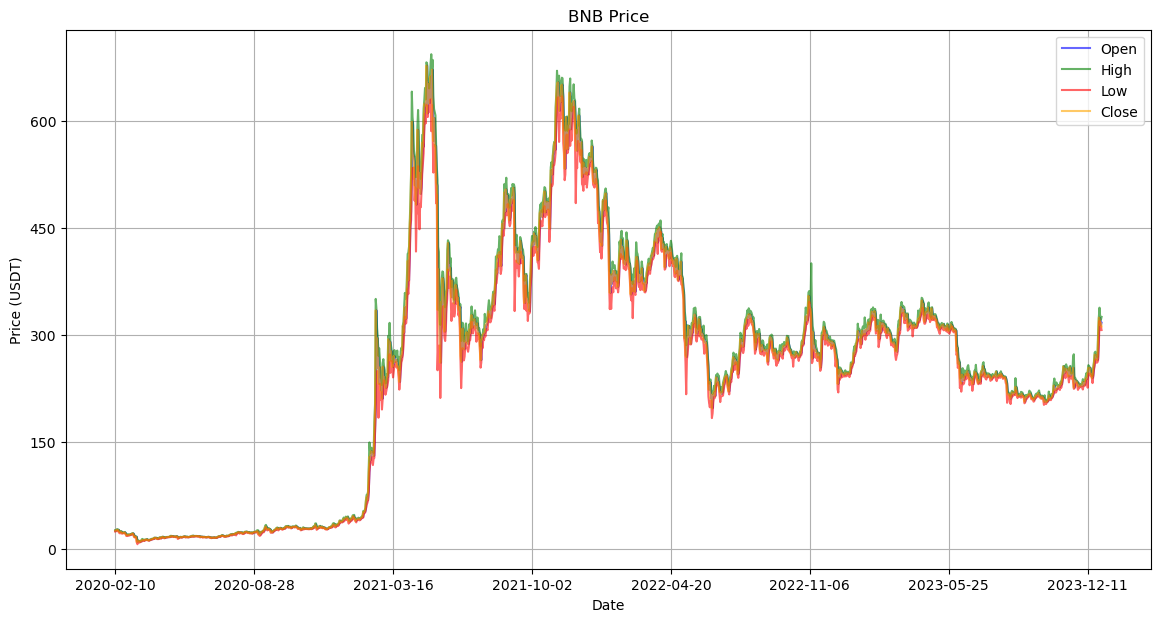

In [4]:
plotPriceDatas(bnb_data, 'BNB Price')

In [12]:
# Fetch historical data
# btc_data = fetchHistoricalData('BTCUSDT', start_date, end_date)
btc_data = pd.read_csv('data/BTCUSDT_1D_2.csv')

       Open Time      Open      High       Low     Close      volume
0     2020-02-10  10167.37  10213.56   9750.00   9865.56  184242.737
1     2020-02-11   9865.56  10409.96   9729.36  10229.06  190119.815
2     2020-02-12  10230.74  10479.98  10229.71  10339.99  159674.258
3     2020-02-13  10339.64  10540.00  10101.00  10239.63  213052.717
4     2020-02-14  10240.02  10390.00  10123.37  10356.82  130975.746
...          ...       ...       ...       ...       ...         ...
1416  2023-12-27  42538.60  43700.00  42145.70  43453.80  251351.538
1417  2023-12-28  43453.80  43850.00  42320.50  42600.10  257515.182
1418  2023-12-29  42600.10  43171.90  41283.20  42095.10  337421.865
1419  2023-12-30  42095.10  42654.60  41550.00  42174.20  183890.670
1420  2023-12-31  42174.30  42951.00  42001.00  42314.00  173508.289

[1421 rows x 6 columns]


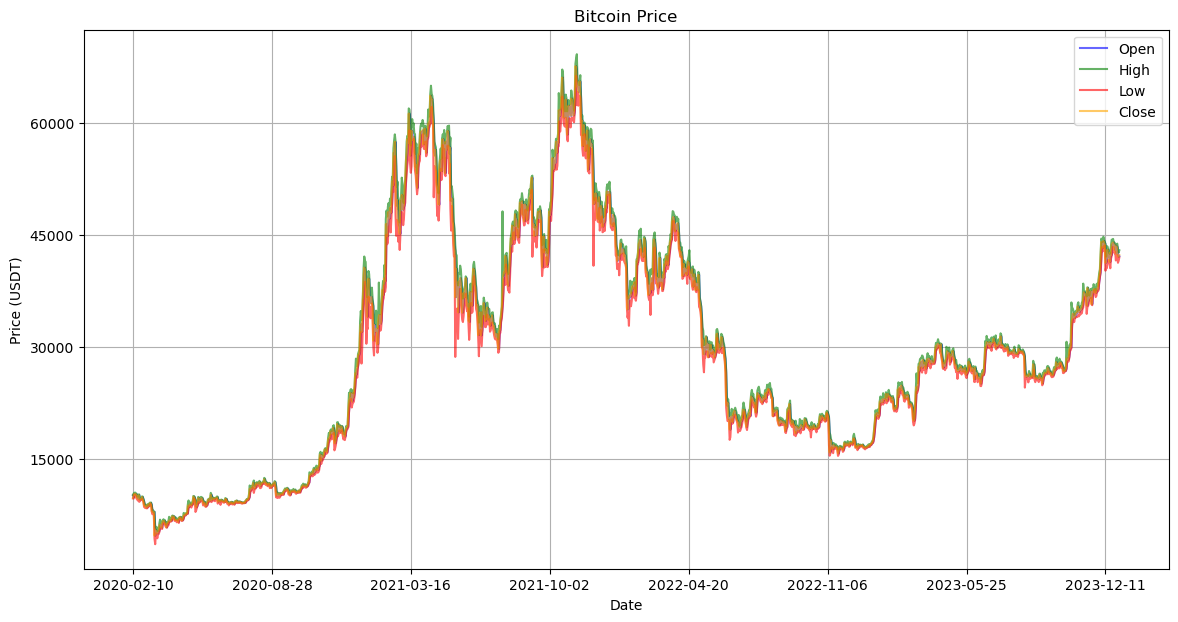

In [13]:
if btc_data is not None:
    print(btc_data)

plotPriceDatas(btc_data, 'Bitcoin Price')

In [14]:
dataSize = len(btc_data)
assert(dataSize == len(bnb_data))
windowSize = 35
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

dataSize: 1421
windowSize: 35
testSize: 426


In [15]:
testingOutput = prepareTestingOutputs(bnb_data["Close"], testSize)
print(testingOutput)

[323.67 319.98 329.36 354.36 348.97 337.69 336.81 326.95 266.52 303.84
 290.08 282.67 276.41 278.85 276.83 271.7  267.82 273.89 272.33 264.11
 253.92 266.62 298.49 299.86 300.43 310.95 307.36 293.16 295.13 300.11
 292.3  293.49 290.35 291.95 288.39 290.21 284.02 290.34 285.91 288.03
 284.38 276.14 272.34 267.7  258.85 230.74 241.75 250.78 240.23 251.09
 246.07 245.69 245.95 244.31 243.11 244.26 246.52 244.42 246.12 245.74
 246.11 244.36 245.07 245.97 258.54 256.44 259.69 261.11 274.7  272.44
 277.02 284.74 287.52 293.67 305.25 302.2  299.02 299.28 286.44 294.4
 305.24 299.12 303.19 305.36 300.32 306.84 304.68 308.07 306.08 317.12
 307.18 312.15 317.2  323.72 332.38 330.41 327.94 324.57 333.15 328.28
 305.91 305.52 310.22 312.26 294.04 296.06 317.26 304.07 312.94 316.21
 311.25 315.28 311.4  312.39 308.2  302.11 302.18 308.42 304.5  301.18
 302.48 299.79 290.34 289.45 288.58 287.63 289.14 286.9  276.89 277.04
 275.82 288.04 307.93 308.67 306.43 329.05 338.63 330.82 335.81 332.08
 334.52

### Brenchmarking with "trivial prediction"

Trivial prediction is a simple model that predict the next date value as the current one.

[325.59 323.67 319.98 329.36 354.36 348.97 337.69 336.81 326.95 266.52
 303.84 290.08 282.67 276.41 278.85 276.83 271.7  267.82 273.89 272.33
 264.11 253.92 266.62 298.49 299.86 300.43 310.95 307.36 293.16 295.13
 300.11 292.3  293.49 290.35 291.95 288.39 290.21 284.02 290.34 285.91
 288.03 284.38 276.14 272.34 267.7  258.85 230.74 241.75 250.78 240.23
 251.09 246.07 245.69 245.95 244.31 243.11 244.26 246.52 244.42 246.12
 245.74 246.11 244.36 245.07 245.97 258.54 256.44 259.69 261.11 274.7
 272.44 277.02 284.74 287.52 293.67 305.25 302.2  299.02 299.28 286.44
 294.4  305.24 299.12 303.19 305.36 300.32 306.84 304.68 308.07 306.08
 317.12 307.18 312.15 317.2  323.72 332.38 330.41 327.94 324.57 333.15
 328.28 305.91 305.52 310.22 312.26 294.04 296.06 317.26 304.07 312.94
 316.21 311.25 315.28 311.4  312.39 308.2  302.11 302.18 308.42 304.5
 301.18 302.48 299.79 290.34 289.45 288.58 287.63 289.14 286.9  276.89
 277.04 275.82 288.04 307.93 308.67 306.43 329.05 338.63 330.82 335.81
 332.08 

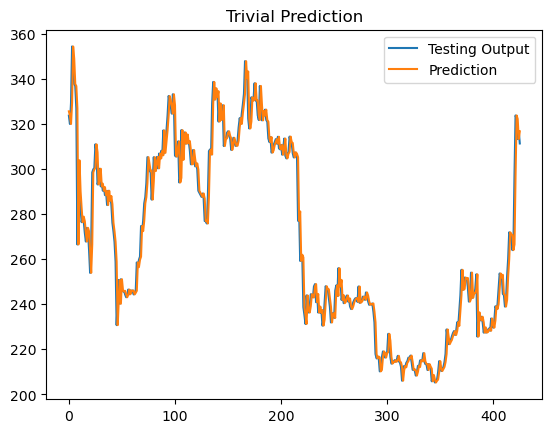

In [16]:
prediction0 = np.array(bnb_data["Close"][range(dataSize - testSize - 1, dataSize - 1)])
print(prediction0)
plt.plot(testingOutput, label="Testing Output")
plt.plot(prediction0, label="Prediction")
plt.title("Trivial Prediction")
plt.legend()

rmse0 = tf.keras.metrics.RootMeanSquaredError()(testingOutput, prediction0)
print(f"RootMeanSquaredError {rmse0}")

# calculate the correlation between the prediction and the actual values
corr0 = np.corrcoef(prediction0, testingOutput)[0, 1]
print(f"Correlation {corr0}")

### N-Beat Alogrithm
#### [Model1] BNB closing price -> BNB closing price

In [17]:
x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)
x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

In [18]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 35), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 35), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [19]:
nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize), name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 35)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 35),         824868      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 35)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                              

In [20]:
model1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [21]:
history1 = model1.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 173: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 273: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


14/14 [==============================] - 6s 30ms/step - loss: 6.1283 - mae: 6.1283 - mse: 82.8219
rmse1: 9.100652952138843


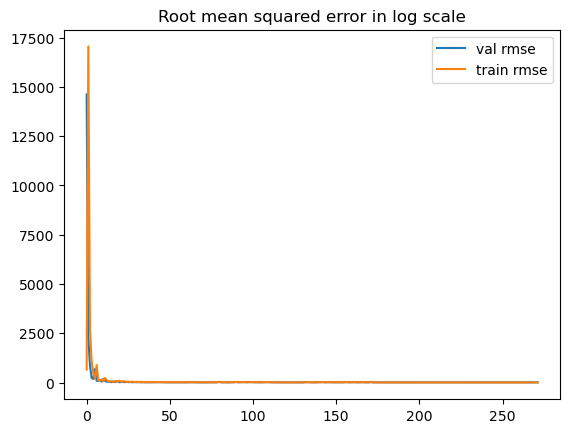

In [22]:
plotHistoryRSME(history1, 300)

rmse1 = np.sqrt(model1.evaluate(x_test, y_test)[2])
print(f"rmse1: {rmse1}")


In [23]:
# model1.save('models/model1-1')

corr: 0.9756305136711744


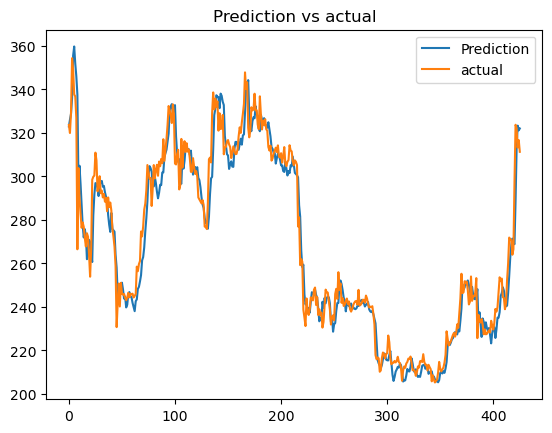

In [24]:
# plot prediction
prediction1 = model1.predict(x_test)
plt.plot(prediction1, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr1 = np.corrcoef(prediction1.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr1}")

#### [Model2] BNB+BTC closing price -> BNB closing price
##### Appending BTC data after BNB data as input

In [25]:
# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize)
x_train2 = [np.concatenate((x_train[i], x_train_btc[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
y_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize)
x_test2 = [np.concatenate((x_test[i], y_test_btc[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train2)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test2)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 70), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 70), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [26]:
nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model2 = tf.keras.Model(inputs=input, outputs=x)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 70)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 70),         860743      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 70)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                            

In [27]:
model2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [28]:
history2 = model2.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 186: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 523: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 623: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


14/14 [==============================] - 2s 26ms/step - loss: 82.0987 - mae: 82.0987 - mse: 10862.0449
rmse2: 104.22113471784405


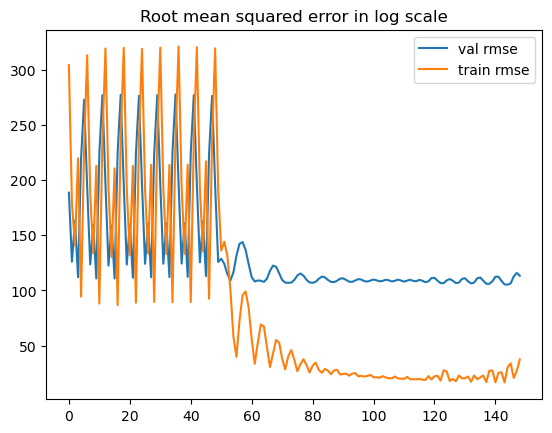

In [29]:
rmse2 = np.sqrt(model2.evaluate(np.array(x_test2), y_test)[2])
print(f"rmse2: {rmse2}")

plotHistoryRSME(history2)

#### [Model3] Fix
It's weird to have higher error with more data. Let's try normalize BTC price first.

In [30]:
print(f"x_train mean: {np.mean(x_train)}")
print(f"x_train_btc mean: {np.mean(x_train_btc)}")
np.mean(x_train_btc) / np.mean(x_train)

x_train mean: 250.96987330357146
x_train_btc mean: 30981.040240178572


123.4452559280058

BTC is about 90 times higher than BNB. Let's scale it down by 90.

In [31]:
BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_train3 = [np.concatenate((x_train[i], x_train_btc[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_test3 = [np.concatenate((x_test[i], x_test_btc[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train3)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test3)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model3 = tf.keras.Model(inputs=input, outputs=x)
# model3.summary()

model3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history3 = model3.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 162: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 262: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


14/14 [==============================] - 2s 23ms/step - loss: 9.9613 - mae: 9.9613 - mse: 184.0077
rmse3: 13.564943436287802
corr: 0.9476730672581135


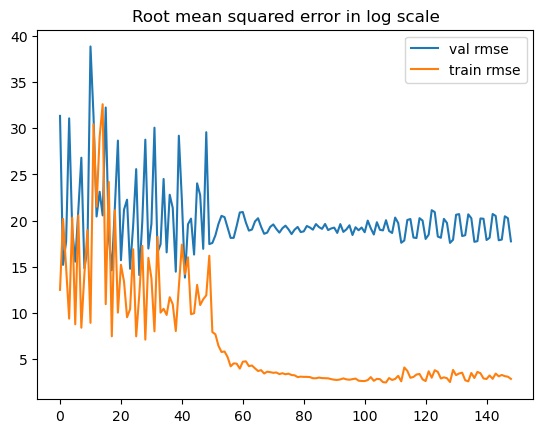

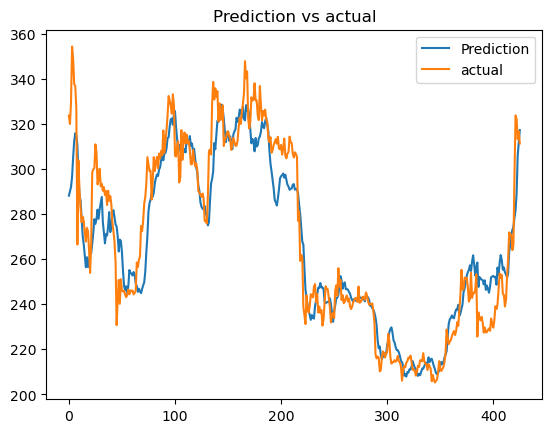

In [32]:
rmse3 = np.sqrt(model3.evaluate(np.array(x_test3), y_test)[2])
print(f"rmse3: {rmse3}")

plotHistoryRSME(history3)
plt.figure()

# plot prediction
prediction3 = model3.predict(np.array(x_test3))
plt.plot(prediction3, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr3 = np.corrcoef(prediction3.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr3}")

#### [Model4] Swap input position

Lets try putting BTC values before BNB values.

In [33]:
# BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
# x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_train4 = [np.concatenate((x_train_btc[i], x_train[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
# x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_test4 = [np.concatenate((x_test_btc[i], x_test[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train4, y_train, x_test4, y_test)

In [34]:
nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model4 = tf.keras.Model(inputs=input, outputs=x)
# model4.summary()

model4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history4 = model4.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 171: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 271: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


14/14 [==============================] - 2s 21ms/step - loss: 10.6047 - mae: 10.6047 - mse: 188.5947
rmse4: 13.732979522394258
corr: 0.9446678837110047


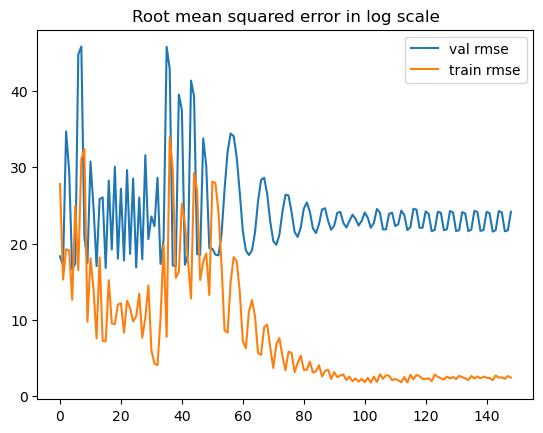

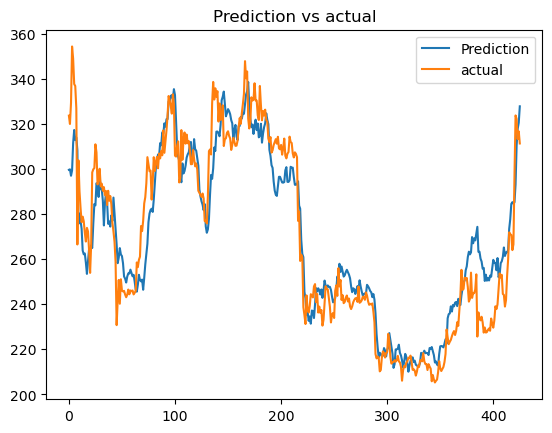

In [35]:
rmse4 = np.sqrt(model4.evaluate(np.array(x_test4), y_test)[2])
print(f"rmse4: {rmse4}")

# plot error
plotHistoryRSME(history4)
plt.figure()

# plot prediction
prediction4 = model4.predict(np.array(x_test4))
plt.plot(prediction4, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr4 = np.corrcoef(prediction4.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr4}")

#### [Model5] Increase Neuron

It seems that BTC data would confuse the model, or it doesn't have enough unit to process the data. Let's try to increase the neuron number.

In [36]:
# BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
# x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
# x_train4 = [np.concatenate((x_train_btc[i], x_train[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
# x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
# x_test4 = [np.concatenate((x_test_btc[i], x_test[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train4, y_train, x_test4, y_test)

nbeatNeuronCount = round(512 * np.power(2, 0.5)) # the number of attributes should be increased by 2
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model5 = tf.keras.Model(inputs=input, outputs=x)
model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 70)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 70),         1677579     ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 70)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                            

In [37]:
model5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history5 = model5.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 265: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


14/14 [==============================] - 2s 16ms/step - loss: 9.9951 - mae: 9.9951 - mse: 164.7337
rmse5: 12.834864603479401
corr: 0.9556388230647447


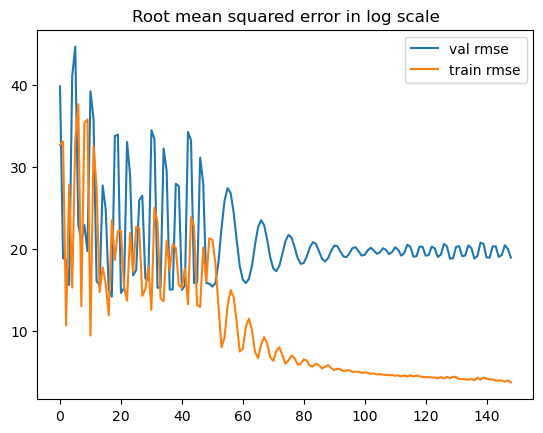

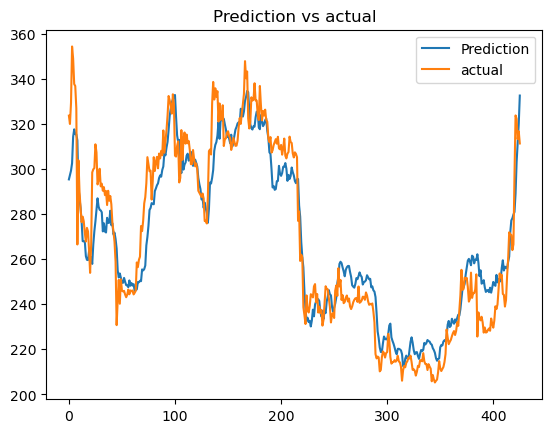

In [38]:
rmse5 = np.sqrt(model5.evaluate(np.array(x_test4), y_test)[2])
print(f"rmse5: {rmse5}")

# plot error
plotHistoryRSME(history5)
plt.figure()

# plot prediction
prediction5 = model5.predict(np.array(x_test4))
plt.plot(prediction5, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr5 = np.corrcoef(prediction5.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr5}")

#### Conclusion

The model with BTC data seems performs worse that without it. Lets try with more data and larger window size next time.

<BarContainer object of 5 artists>

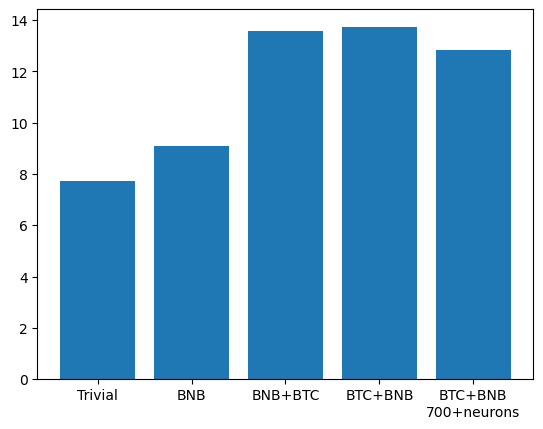

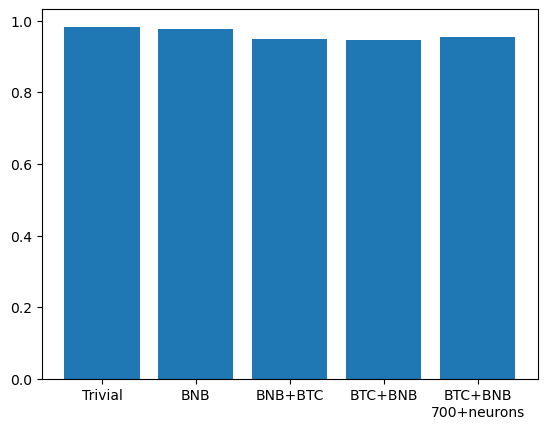

In [39]:
models = ["Trivial", "BNB", "BNB+BTC", "BTC+BNB", "BTC+BNB\n700+neurons"]
rmses = [rmse0, rmse1, rmse3, rmse4, rmse5]
plt.bar(models, rmses)

plt.figure()
corrs = [corr0, corr1, corr3, corr4, corr5]
plt.bar(models, corrs)